## Lecture 5 - Convolution
In this lecture:

- Introduction to convolution
- The convolution layer in Keras and its uses 
- Latent representations powered by convolution


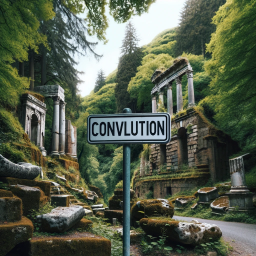

At its core, convolution is a mathematical operation that combines two functions or signals to produce a third function. It essentially shows how the shape of one is modified by the other. Imagine you have two signals (or functions), and you want to understand how one signal modifies or affects the other. Convolution provides a way to do this.

How can we use convolution in neural networks?

The convolutional layer is the core building block of Convoluted Neural Networks, and it is where the majority of computation occurs. It requires a few components, which are input data, a filter, and a feature map. Let’s assume that the input will be a color image, which is made up of a matrix of pixels in 3D. This means that the input will have three dimensions—a height, width, and depth—which correspond to RGB in an image. We also have a feature detector, also known as a kernel or a filter, which will move across the receptive fields of the image, checking if the feature is present. 

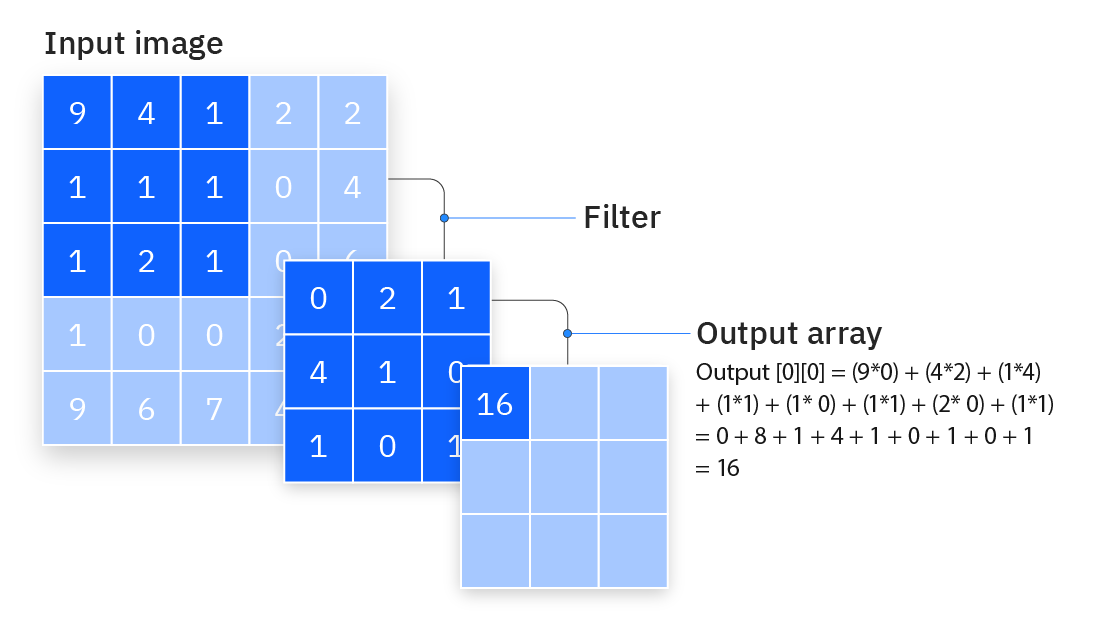

The feature detector is a two-dimensional (2-D) array of weights, which represents part of the image. While they can vary in size, the filter size is typically a 3x3 matrix; this also determines the size of the receptive field. The filter is then applied to an area of the image, and a dot product is calculated between the input pixels and the filter. This dot product is then fed into an output array. Afterwards, the filter shifts by a stride, repeating the process until the kernel has swept across the entire image. __The final output from the series of dot products from the input and the filter is known as a feature map, activation map, or a convolved feature__

### Why is convolution useful in neural network design?

__Local Feature Detection__: Convolution operations are excellent for detecting local features such as edges, textures, and shapes in images. Since these local features are often the building blocks of more complex patterns, convolution allows neural networks to build up an understanding of images in a hierarchical manner.

__Parameter Efficiency__: Traditional neural networks (fully connected networks) require a vast number of parameters, leading to increased computational cost and higher risk of overfitting. Convolution layers share parameters across the entire input, significantly reducing the number of parameters and making the network more efficient and scalable.

__Translational Invariance__: Convolutional networks learn to recognize patterns regardless of their position in the input space. This property, known as translational invariance, means that once the network learns a feature (like an edge in a specific orientation), it can recognize that feature anywhere in the input

__Hierarchical Feature Learning__: In CNNs, layers are arranged hierarchically. Lower layers tend to learn simple features like edges or basic textures, while higher layers combine these simple features to detect more complex patterns. This hierarchical approach is effective for understanding complex structures in data.

Note that the weights in the feature detector remain fixed as it moves across the image, which is also known as parameter sharing. Some parameters, like the weight values, adjust during training through the process of backpropagation and gradient descent. However, there are three hyperparameters which affect the volume size of the output that need to be set before the training of the neural network begins. These include:

 - Number of features, the number of kernels. This parameter set the number of output dimensions, for example with 1 I would have an output dimension of (64,64,1), with 3 it would be (64,64,3)
 - Stride, it represents the "jump" the kernel does while convolving the image. A padding > 1 will "compress" the feature response, for example using a stride of 2 will transorm an imput of (64,64,1) into (32,32,1) 
 - Padding is used to address the filter behaviour on the border areas. 
    - Valid padding: This is also known as no padding. In this case, the last convolution is dropped if dimensions do not align.
    - Same padding: This padding ensures that the output layer has the same size as the input layer
 


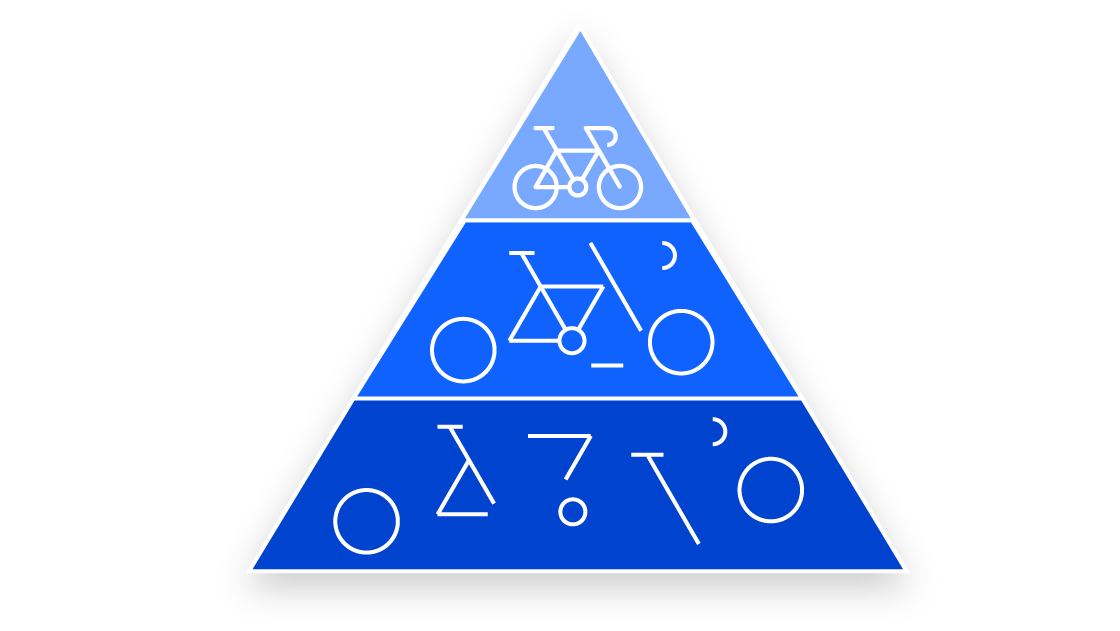

We now look at a basic implementation of convolution: 

In [2]:
import numpy as np

class Conv2D:
    def __init__(self, num_filters, kernel_size):
        self.num_filters = num_filters
        self.kernel_size = kernel_size
        self.kernels = np.random.randn(num_filters, kernel_size, kernel_size) / (kernel_size * kernel_size)
        self.biases = np.zeros(num_filters)

    def iterate_regions(self, image):
        """
        Generates image regions and their corresponding coordinates.
        """
        h, w = image.shape

        for i in range(h - self.kernel_size + 1):
            for j in range(w - self.kernel_size + 1):
                image_region = image[i:(i + self.kernel_size), j:(j + self.kernel_size)]
                yield image_region, i, j

    def forward(self, input):
        """
        Perform a forward pass of the conv layer using the given input.
        Returns a 3d numpy array with dimensions (h, w, num_filters).
        """
        h, w = input.shape
        output = np.zeros((h - self.kernel_size + 1, w - self.kernel_size + 1, self.num_filters))

        for image_region, i, j in self.iterate_regions(input):
            output[i, j] = np.sum(image_region * self.kernels, axis=(1, 2)) + self.biases

        return output

Let's solve the mnist problem using convolution

In [4]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

num_classes = 10
input_shape = (28, 28, 1)

# Load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

2023-11-19 11:45:21.544528: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [100]:
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Add, BatchNormalization, Dropout, UpSampling2D
from keras.datasets import mnist
from keras.utils import to_categorical

inputs = Input(shape=input_shape)
x = layers.Conv2D(32, kernel_size=(3, 3),padding = "valid", activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(64, kernel_size=(3, 3), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)


model = Model(inputs=inputs, outputs=outputs)

In [28]:
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 13, 13, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 5, 5, 64)         0         
 g2D)                                                            
                                                                 
 flatten_8 (Flatten)         (None, 1600)              0   

#### Discussing dimensionality

it's important to understand how they change in relation to the parameters of convolution

(None, 28, 28, 1) -> (None, 26, 26, 32)

We are losing 2 spatial values because of padding, and we have now 32 in the "channel" dimension because of the numebr of filters. 

If we use a kernel with dimension 5x5, what is the output dimension with valid padding?

And the number of parameters? (3x3) * 32 + 32 = 320

__How to choose which padding to use?__

Generally speaking, it's a minor problem. The biggest argument in choosing the correct padding is what kind of spatial dimensions I need to have. Sometimes reducing the overall size is good and more efficient, some other times preserving spatial dimension is cruciall. Beware that same padding may cause some irregularities in the border areas.

#### A peculiar example, earth padding

The following image report the value of Z500 metereological variable for the whole world (with a cylindrical projection). In this case, what padding should we use?

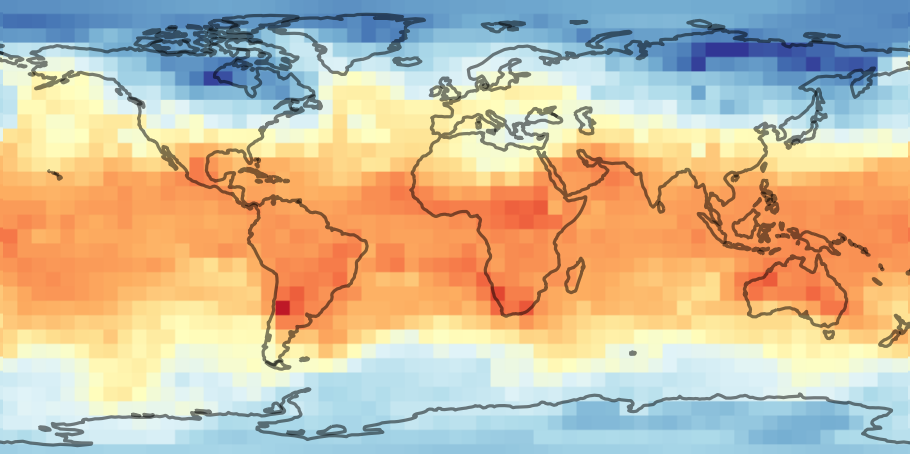

The east and west borders are actually the same, we can implement padding between the two. 

#### Should I use max_pooling or a convolution with stride > 1? 

Reasons to choose max pooling
- Feature Preservation: Max pooling is effective at preserving the most significant features (like edges in an image), as it selects the maximum value over the window it processes.
- Overfitting Reduction: It can help reduce overfitting by providing an abstracted form of the representations.
- Computational Efficiency: Max pooling reduces the computational load for the subsequent layers by reducing the number of parameters.
- Translation Invariance: It introduces a small amount of translation invariance, making the model less sensitive to the exact location of features.

Reasons to choose convolution with stride > 1

- Parameter Learning: Unlike max pooling, a convolutional layer with a stride of 2 has learnable parameters. This can potentially lead to learning more complex patterns in the data.
- Data Representation: Since it involves learning, it may represent the data better than max pooling, which is a fixed operation.
- Reduction in Spatial Dimension: Like max pooling, it reduces the spatial dimension but does so in a way that is learned from the data.
- Potentially Less Aggressive Downsampling: Depending on the filter size, this method might be less aggressive in downsampling compared to max pooling.

In theory, a convolutional layer with a stride greater than 1 could learn a function that mimics max pooling

In [29]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# Train the model
model.fit(x_train, y_train, epochs=5, batch_size=128)
# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_acc}')

Epoch 1/5
469/469 [==============================] - 1s 2ms/step - loss: 0.3344 - accuracy: 0.9002
Epoch 2/5
469/469 [==============================] - 1s 2ms/step - loss: 0.1029 - accuracy: 0.9686
Epoch 3/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0782 - accuracy: 0.9764
Epoch 4/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0640 - accuracy: 0.9806
Epoch 5/5
313/313 [==============================] - 0s 1ms/step - loss: 0.0346 - accuracy: 0.9879
Test accuracy: 0.9879000186920166


Convolution is practical for this task, it performs better than Dense layers. 

#### (1x1) convolution
1x1 convolution is a special kind of convolution, using a filter of size 1. Can you guess what is it useful for? 

It let us operate a reshape in the feature channels, it can also mix the content of different channels providing more sophisticated behaviour to the network

Let's see an example

In [99]:
inputs = Input(shape=input_shape)
x = layers.Conv2D(32, kernel_size=(3, 3),padding = "same", activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(64, kernel_size=(3, 3), activation="relu")(x)
#x = layers.MaxPooling2D(pool_size=(2, 2))(x)

x = layers.Conv2D(1, kernel_size=1, activation = "relu")(x)

x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)


model = Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_38 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_60 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_61 (Conv2D)          (None, 12, 12, 64)        18496     
                                                                 
 conv2d_62 (Conv2D)          (None, 12, 12, 1)         65        
                                                                 
 flatten_22 (Flatten)        (None, 144)               0         
                                                          

In [40]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# Train the model
model.fit(x_train, y_train, epochs=5, batch_size=128)
# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_acc}')

Epoch 1/5
469/469 [==============================] - 2s 3ms/step - loss: 1.0862 - accuracy: 0.6325
Epoch 2/5
469/469 [==============================] - 1s 2ms/step - loss: 0.5111 - accuracy: 0.8392
Epoch 3/5
469/469 [==============================] - 1s 3ms/step - loss: 0.4224 - accuracy: 0.8697
Epoch 4/5
469/469 [==============================] - 1s 3ms/step - loss: 0.3737 - accuracy: 0.8852
Epoch 5/5
313/313 [==============================] - 1s 1ms/step - loss: 0.1599 - accuracy: 0.9537
Test accuracy: 0.9537000060081482


This situation is now particularly interesting, the model performs ok, but we also have this interesting layer, towards the end of the network, with size 12x12. 

What if we want to take a look at it? 

We can split the model in two parts, here is how we do that:

In [46]:
inputs = Input(shape=input_shape)
x = layers.Conv2D(32, kernel_size=(3, 3),padding = "same", activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(64, kernel_size=(3, 3), activation="relu")(x)
#x = layers.MaxPooling2D(pool_size=(2, 2))(x)
encoded_output = layers.Conv2D(1, kernel_size=1, activation = "relu")(x)

encoder = Model(inputs, encoded_output, name = "part1")
encoder.summary()

decoder_input = layers.Input(shape=(12,12,1))
x = layers.Flatten()(decoder_input)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

decoder = Model(decoder_input, outputs, name = "part2")
decoder.summary()

Model: "part1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_48 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_49 (Conv2D)          (None, 12, 12, 64)        18496     
                                                                 
 conv2d_50 (Conv2D)          (None, 12, 12, 1)         65        
                                                                 
Total params: 18,881
Trainable params: 18,881
Non-trainable params: 0
_________________________________________________________

Can we stich up the model like this? 

In [ ]:
model = Model(inputs=inputs, outputs=outputs)
model.summary()

No, It's a broken pipe, we need to conenct the two parts:

In [49]:
model_input = layers.Input(shape=input_shape)
part1_output = encoder(model_input)
part2_output = decoder(part1_output)
full_model = Model(model_input, part2_output, name="full_model")
full_model.summary()

Model: "full_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_30 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 part1 (Functional)          (None, 12, 12, 1)         18881     
                                                                 
 part2 (Functional)          (None, 10)                1450      
                                                                 
Total params: 20,331
Trainable params: 20,331
Non-trainable params: 0
_________________________________________________________________


We now train the model

In [86]:
# Compile the model
full_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# Train the model
full_model.fit(x_train, y_train, epochs=5, batch_size=128)
# Evaluate the model
test_loss, test_acc = full_model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_acc}')

Epoch 1/5
469/469 [==============================] - 1s 3ms/step - loss: 0.2801 - accuracy: 0.9149
Epoch 2/5
469/469 [==============================] - 1s 2ms/step - loss: 0.2633 - accuracy: 0.9212
Epoch 3/5
469/469 [==============================] - 1s 3ms/step - loss: 0.2519 - accuracy: 0.9240
Epoch 4/5
469/469 [==============================] - 1s 3ms/step - loss: 0.2424 - accuracy: 0.9282
Epoch 5/5
313/313 [==============================] - 0s 1ms/step - loss: 0.0918 - accuracy: 0.9704
Test accuracy: 0.9703999757766724


In [87]:
encoded = encoder.predict(x_test[0:8])

1/1 [==============================] - 0s 16ms/step


In [88]:
encoded.shape

(8, 12, 12, 1)

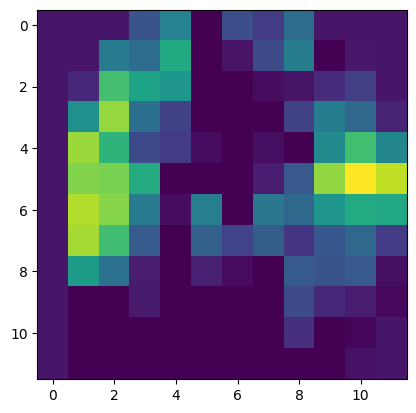

In [89]:
import matplotlib.pyplot as plt
plt.imshow(encoded[3])

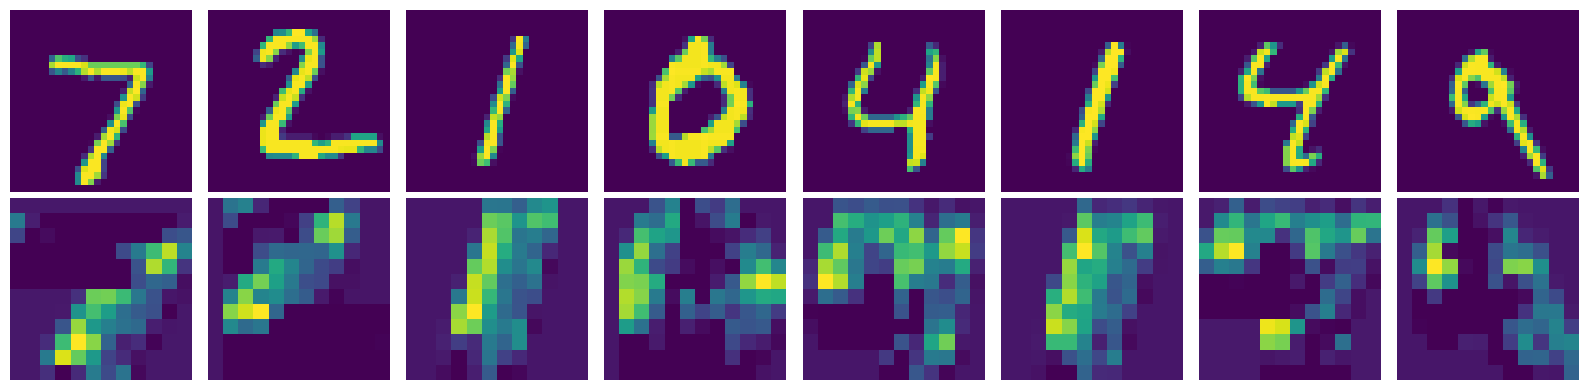

In [90]:
# Number of images
num_images = 8

# Create a figure with 2 rows and num_images columns
fig, axes = plt.subplots(nrows=2, ncols=num_images, figsize=(2 * num_images, 4))

# Plotting images from the first array in the first row
for i in range(num_images):
    axes[0, i].imshow(x_test[0:8][i, :, :, 0])
    axes[0, i].axis('off')

# Plotting images from the second array in the second row
for i in range(num_images):
    axes[1, i].imshow(encoded[i, :, :, 0])
    axes[1, i].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

We are now looking at a latent representation!
What if I change the activation function int the latent layer?

To Better understand this interesting layer, we may want to observe the latent space change during training...

How can we do that? With a callback function

In [91]:
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt

class PlotImagesCallback(Callback):
    def __init__(self):
        super(PlotImagesCallback, self).__init__()

    def on_epoch_end(self, epoch, logs=None):
        num_images = 8  # Number of images to plot

        fig, axes = plt.subplots(nrows=2, ncols=num_images, figsize=(2 * num_images, 4))
        encoded = encoder.predict(x_test[0:8])

        # Plotting images from the x_test array in the first row
        for i in range(num_images):
            axes[0, i].imshow(x_test[0:8][i, :, :, 0])
            axes[0, i].axis('off')

        # Plotting images from the encoded array in the second row
        for i in range(num_images):
            axes[1, i].imshow(encoded[i, :, :, 0])
            axes[1, i].axis('off')

        plt.tight_layout()
        plt.show()
        

plot_callback = PlotImagesCallback()

instantiate the model again

In [93]:
model_input = layers.Input(shape=input_shape)
part1_output = encoder(model_input)
part2_output = decoder(part1_output)
full_model = Model(model_input, part2_output, name="full_model")

Epoch 1/5
1/1 [==============================] - 0s 11ms/steps - loss: 0.2259 - accuracy: 0.93


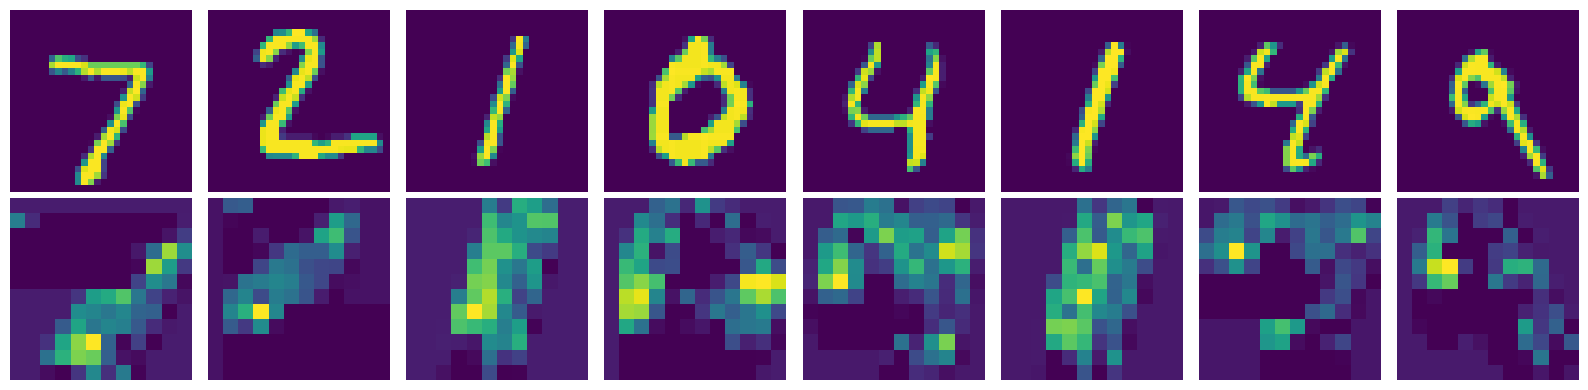

3750/3750 [==============================] - 6s 1ms/step - loss: 0.2266 - accuracy: 0.9317
Epoch 2/5
1/1 [==============================] - 0s 13ms/steps - loss: 0.2186 - accuracy: 0.93


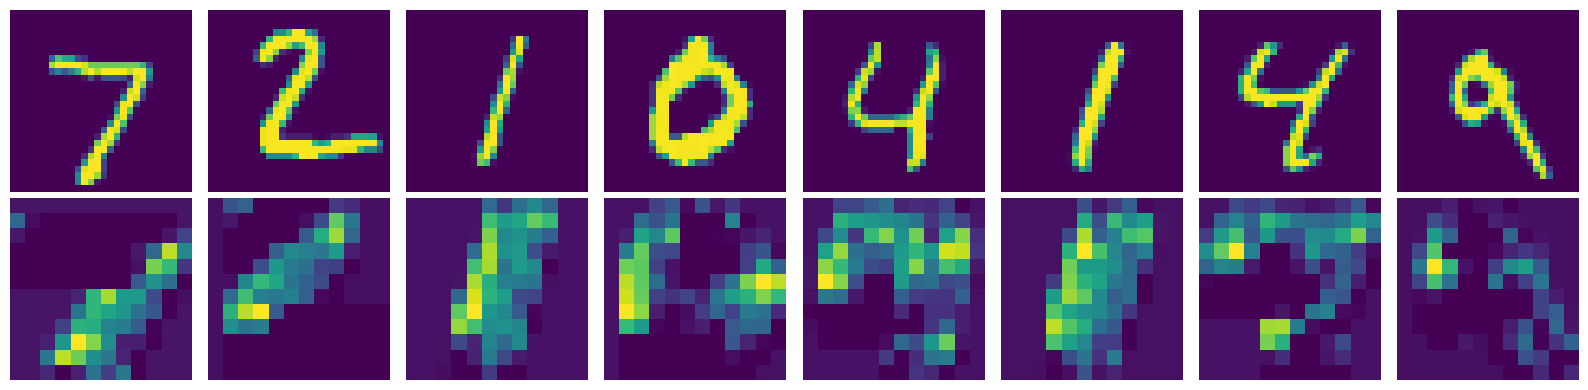

3750/3750 [==============================] - 6s 2ms/step - loss: 0.2188 - accuracy: 0.9341
Epoch 3/5
1/1 [==============================] - 0s 12ms/steps - loss: 0.2127 - accuracy: 0.93


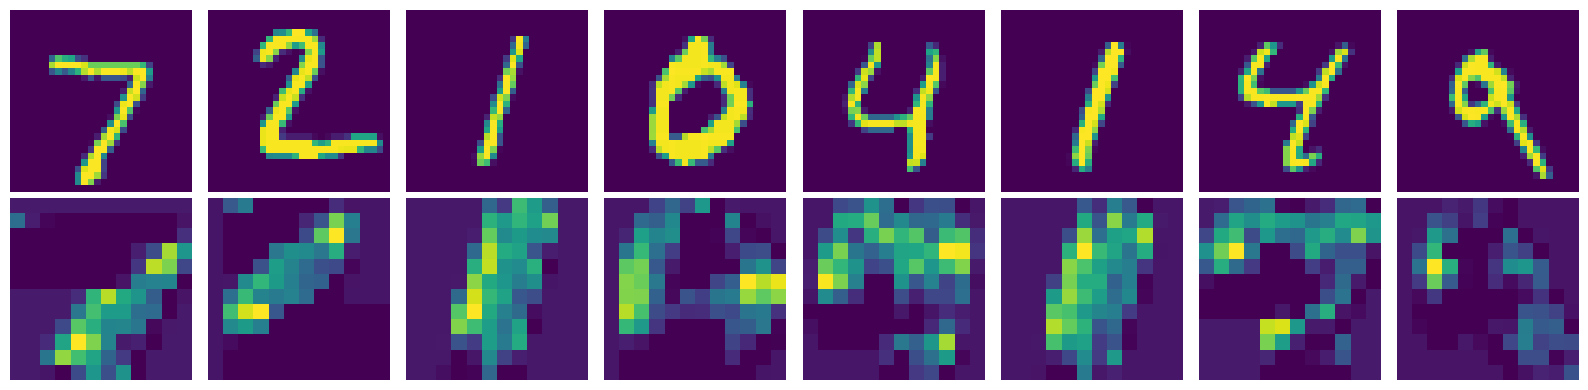

3750/3750 [==============================] - 6s 1ms/step - loss: 0.2127 - accuracy: 0.9366
Epoch 4/5
1/1 [==============================] - 0s 11ms/steps - loss: 0.2066 - accuracy: 0.93


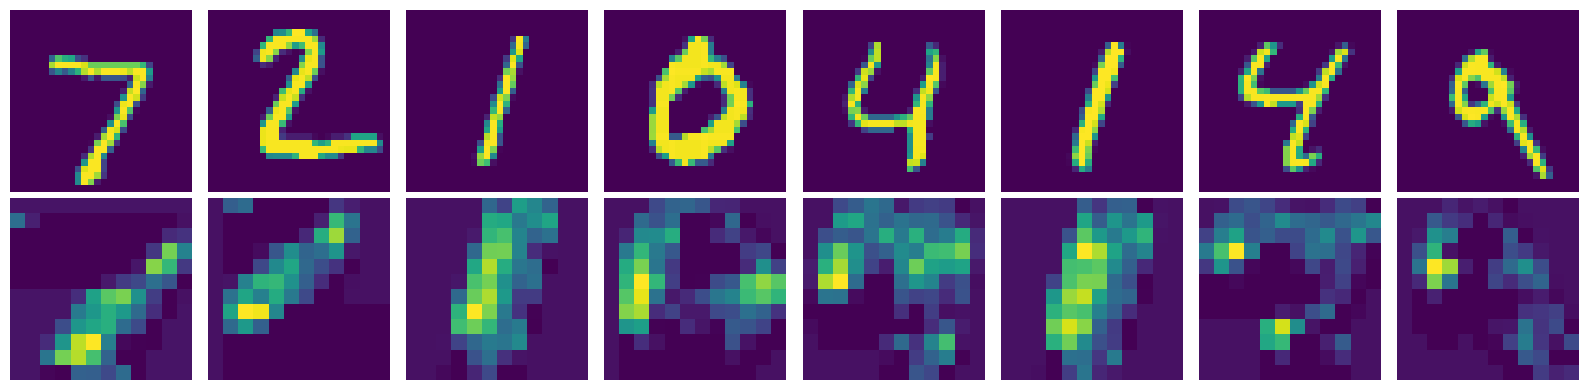

3750/3750 [==============================] - 6s 1ms/step - loss: 0.2067 - accuracy: 0.9378
Epoch 5/5
1/1 [==============================] - 0s 11ms/steps - loss: 0.2041 - accuracy: 0.93


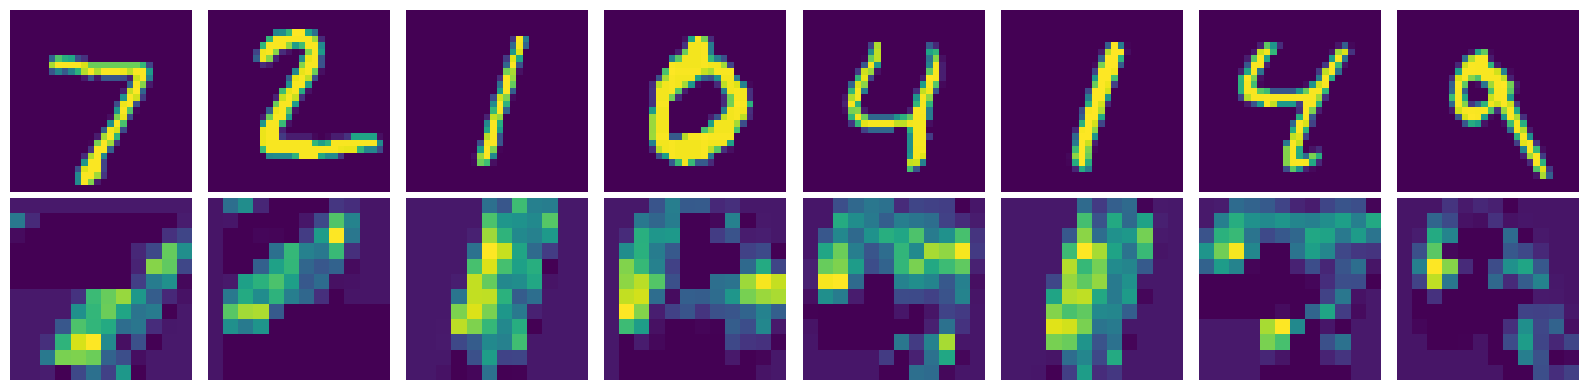

313/313 [==============================] - 0s 1ms/step - loss: 0.0918 - accuracy: 0.9704
Test accuracy: 0.9703999757766724


In [95]:
# Compile the model
full_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# Train the model
full_model.fit(x_train, y_train,callbacks=[plot_callback], epochs=5, batch_size=128)
# Evaluate the model
test_loss, test_acc = full_model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_acc}')

We have now made an encoder, a network that is taking some data and compressing them into a smaller representation, and it is driven in such a way that this "latent" representation is easier to solve for the dense layer at the end of the network.

### Making a full autoencoder
We are now encoding information with the purpose of classifying it. What if our purpose is instead compressing and inflating the data, with the goal of re-creating it? 

Our model would behave in a similiar manner to a jpeg, or png compression. We want ourimage to be smaller, but when needed we want to be able to reconstruct the full version minimizing information loss. 

Any idea on how to build this network?

Pretty simple, we start with the network from above. We rebuild the decoder and change the training data...

In [139]:
inputs = Input(shape=input_shape)
x = layers.Conv2D(32, kernel_size=(3, 3),padding = "same", activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(64, kernel_size=(3, 3),padding = "same", activation="relu")(x)
#x = layers.MaxPooling2D(pool_size=(2, 2))(x)
encoded_output = layers.Conv2D(1, kernel_size=1)(x)

encoder = Model(inputs, encoded_output, name = "part1")
encoder.summary()

decoder_input = layers.Input(shape=(14,14,1))
x = layers.Conv2D(64, kernel_size=(3, 3),padding = "same", activation="relu")(decoder_input)
x = layers.UpSampling2D((2,2))(x)
x = layers.Conv2D(32, kernel_size=(3, 3),padding = "same", activation="relu")(x)

outputs = layers.Conv2D(1, 1, activation="sigmoid")(x)

decoder = Model(decoder_input, outputs, name = "part2")
decoder.summary()

Model: "part1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_70 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_131 (Conv2D)         (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_49 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_132 (Conv2D)         (None, 14, 14, 64)        18496     
                                                                 
 conv2d_133 (Conv2D)         (None, 14, 14, 1)         65        
                                                                 
Total params: 18,881
Trainable params: 18,881
Non-trainable params: 0
_________________________________________________________

Most notable changes : 
- no activation function for the latent space
- sigmoid for the decoder output using 1x1 convolution 
- The use of upsampling 2D

What is the __UpSampling2D__ layer? The simplest of layers.. 

In [140]:
model_input = layers.Input(shape=input_shape)
part1_output = encoder(model_input)
part2_output = decoder(part1_output)
autoencoder = Model(model_input, part2_output, name="autoencoder")

How do we train this model? Not using X -> y but X -> X!
Of course the categorical crossentropy is not correct, we can switch to a mse. 

In [143]:
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt

class autoencoderCallback(Callback):
    def __init__(self):
        super(autoencoderCallback, self).__init__()

    def on_epoch_end(self, epoch, logs=None):
        num_images = 8  # Number of images to plot
        rand = np.random.randint(0,x_test.shape[0])

        fig, axes = plt.subplots(nrows=3, ncols=num_images, figsize=(2 * num_images, 5))
        encoded = encoder.predict(x_test[rand:rand+8])
        decoded = decoder.predict(encoded)
        


        # Plotting images from the x_test array in the first row
        for i in range(num_images):
            axes[0, i].imshow(x_test[rand:rand+8][i, :, :, 0])
            axes[0, i].axis('off')

        # Plotting images from the encoded array in the second row
        for i in range(num_images):
            axes[1, i].imshow(encoded[i, :, :, 0])
            axes[1, i].axis('off')
            
        for i in range(num_images):
            axes[2, i].imshow(decoded[i, :, :, 0])
            axes[2, i].axis('off')

        plt.tight_layout()
        plt.show()
        

autoencoder_callback = autoencoderCallback()

Epoch 1/15
1/1 [==============================] - 0s 12ms/step


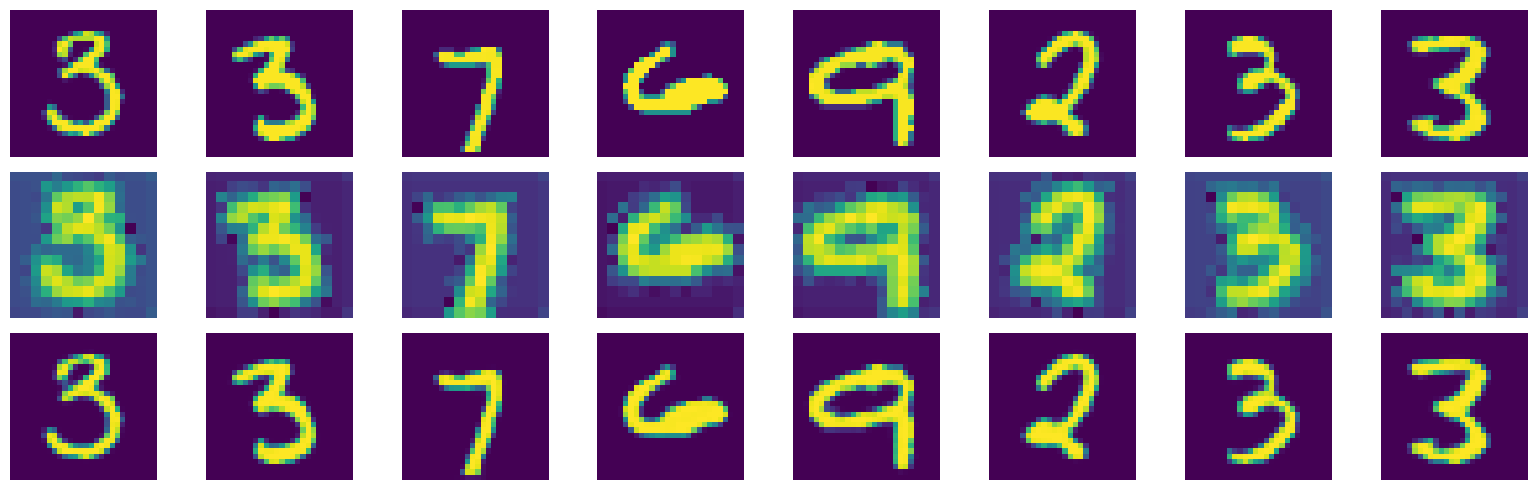

469/469 [==============================] - 4s 8ms/step - loss: 7.8186e-04 - accuracy: 0.8155
Epoch 2/15
1/1 [==============================] - 0s 12ms/step


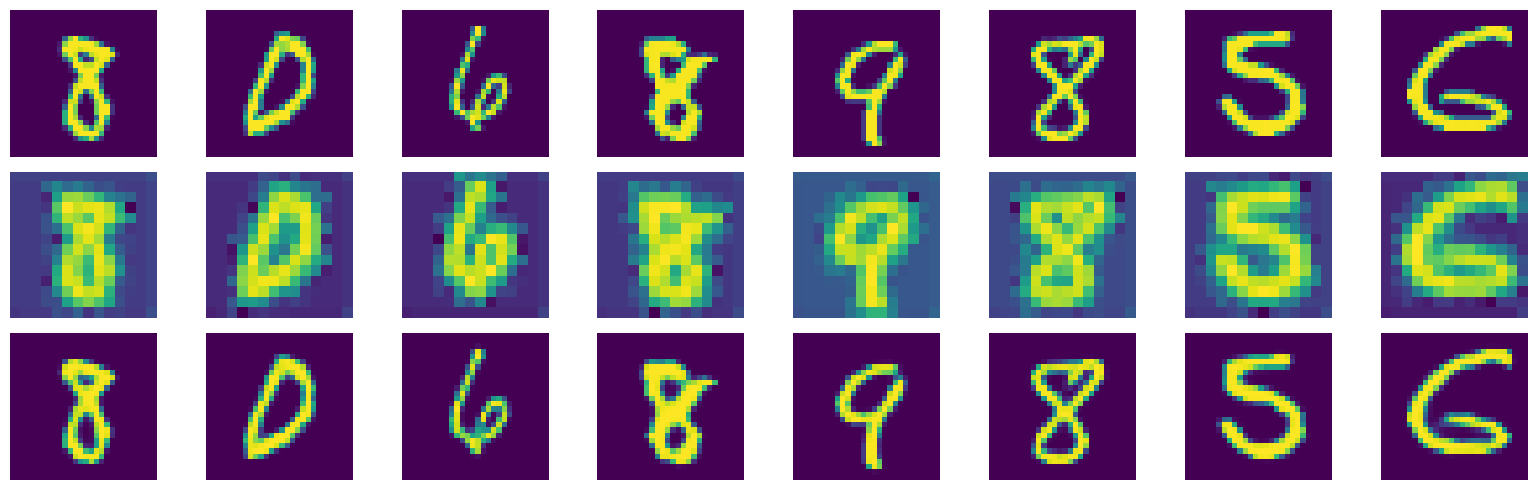

469/469 [==============================] - 3s 7ms/step - loss: 7.1657e-04 - accuracy: 0.8155
Epoch 3/15
1/1 [==============================] - 0s 11ms/step


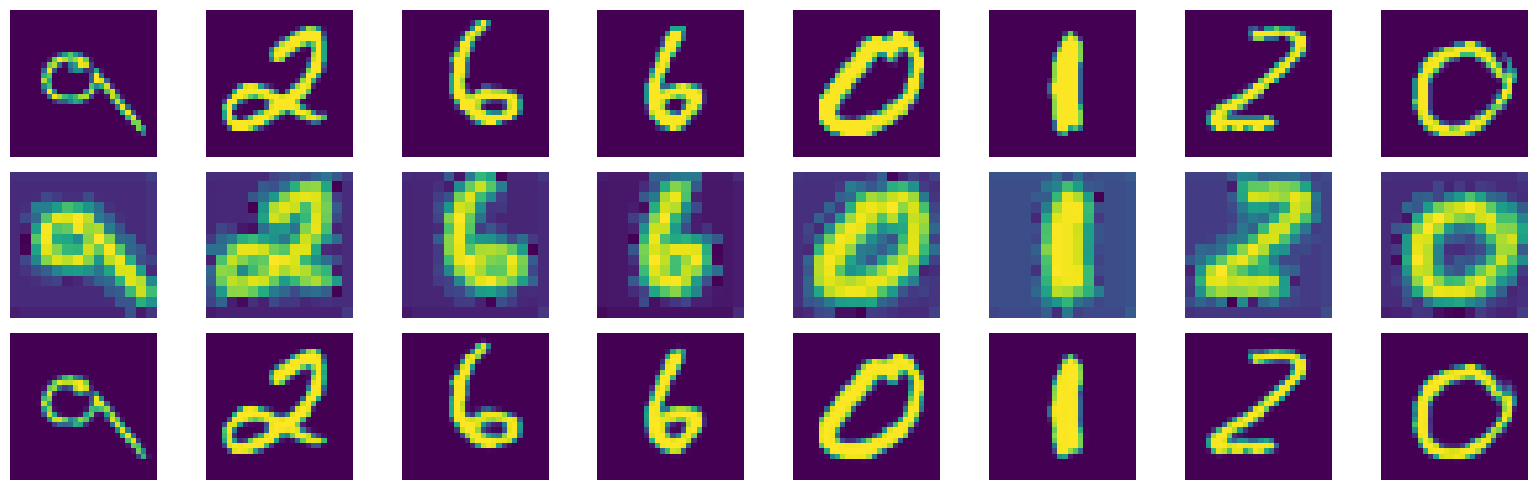

469/469 [==============================] - 3s 7ms/step - loss: 7.1613e-04 - accuracy: 0.8155
Epoch 4/15
1/1 [==============================] - 0s 11ms/step


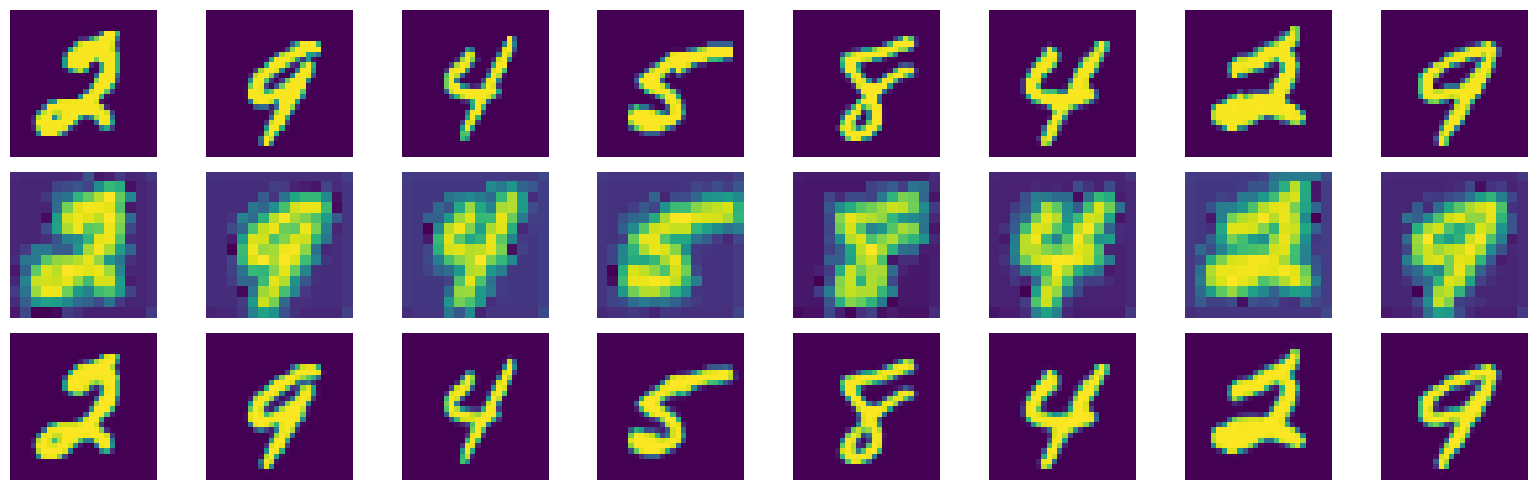

469/469 [==============================] - 3s 7ms/step - loss: 7.1369e-04 - accuracy: 0.8155
Epoch 5/15
1/1 [==============================] - 0s 13ms/step


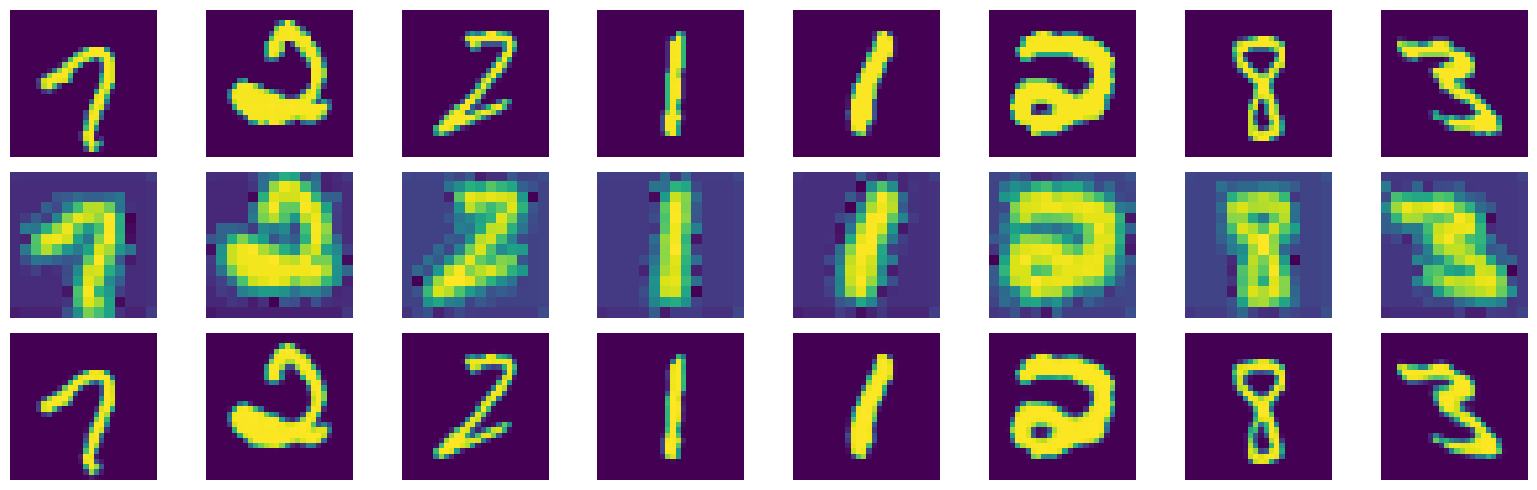

469/469 [==============================] - 4s 8ms/step - loss: 7.0721e-04 - accuracy: 0.8155
Epoch 6/15
1/1 [==============================] - 0s 11ms/step


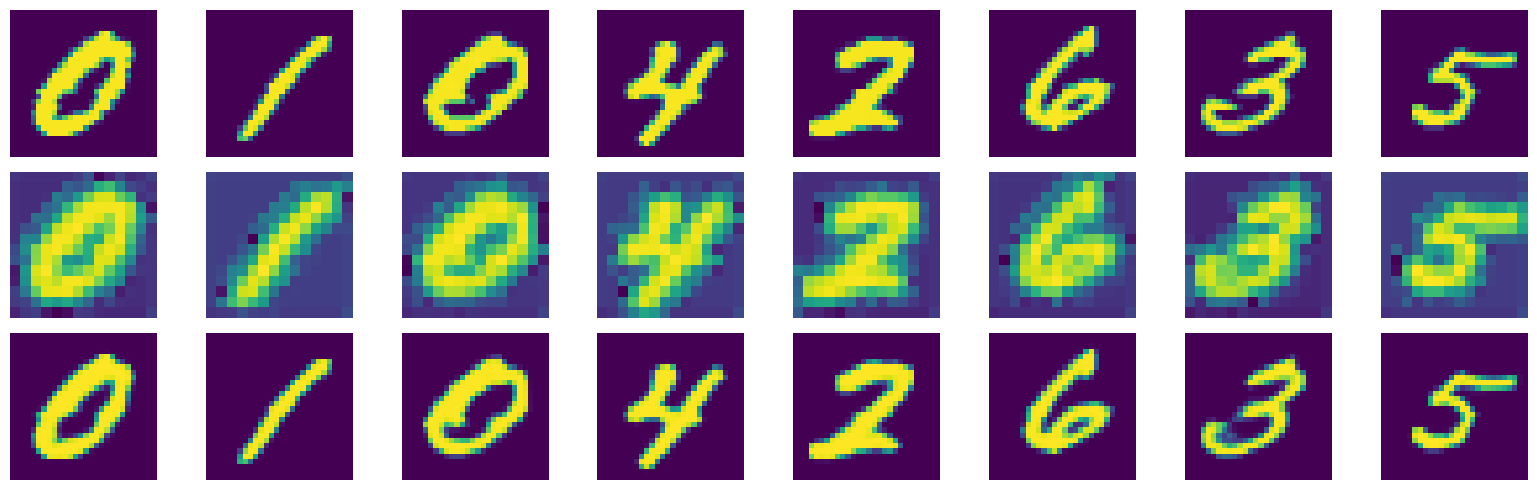

469/469 [==============================] - 3s 7ms/step - loss: 7.0179e-04 - accuracy: 0.8155
Epoch 7/15
1/1 [==============================] - 0s 11ms/step


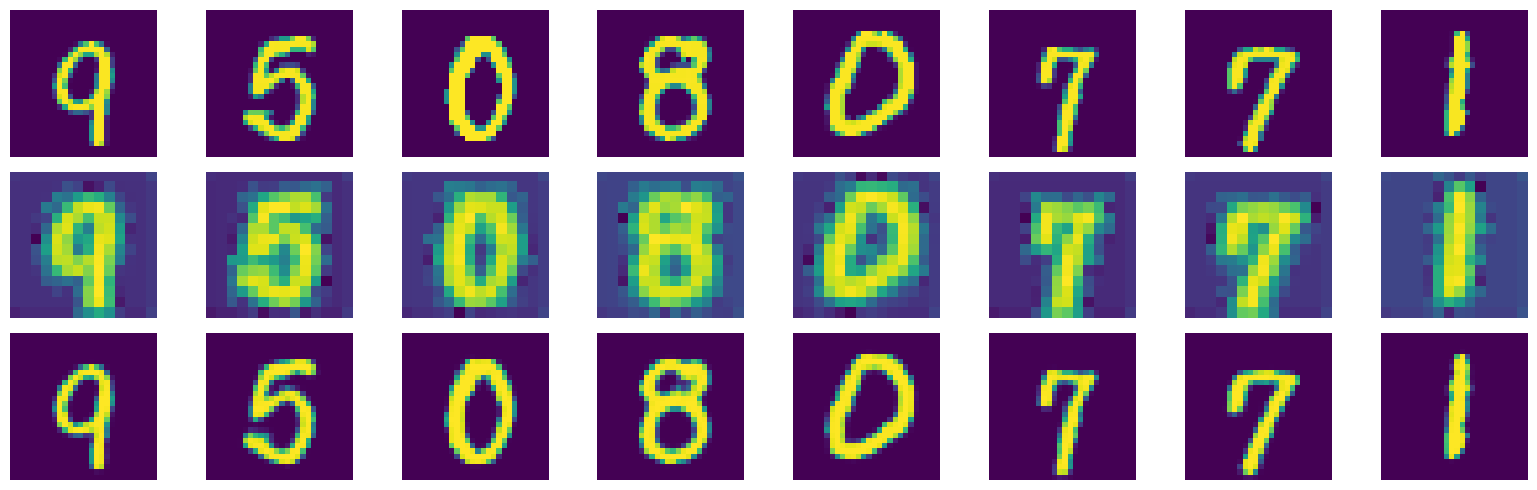

469/469 [==============================] - 3s 7ms/step - loss: 6.9847e-04 - accuracy: 0.8155
Epoch 8/15
1/1 [==============================] - 0s 11ms/step


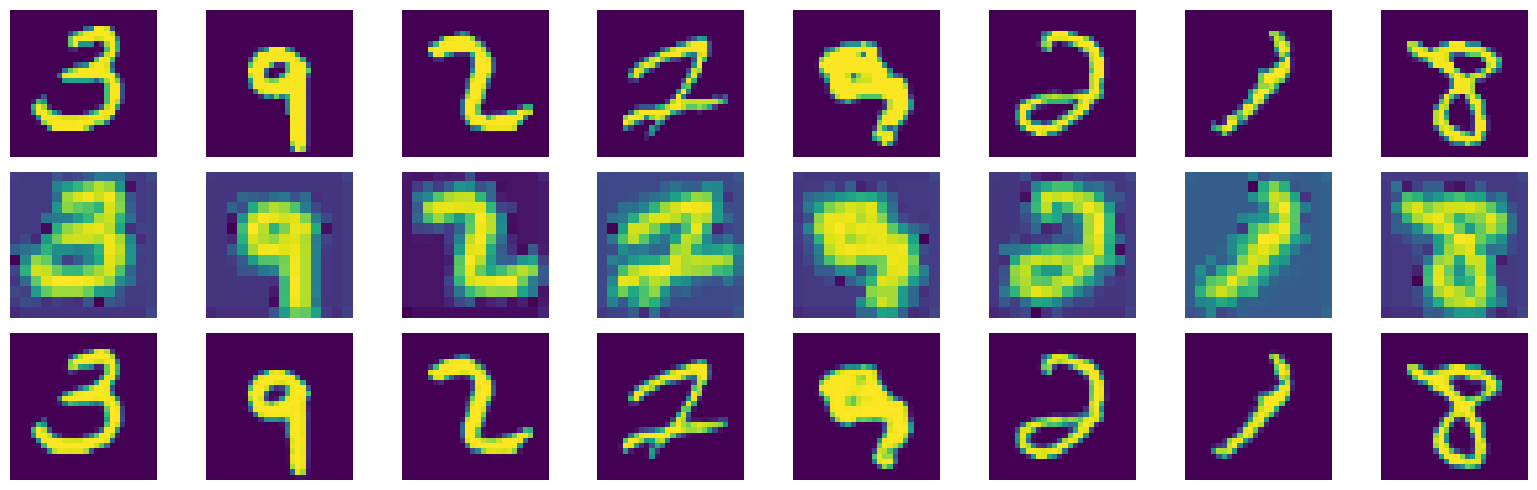

469/469 [==============================] - 3s 7ms/step - loss: 6.9232e-04 - accuracy: 0.8155
Epoch 9/15
1/1 [==============================] - 0s 12ms/step


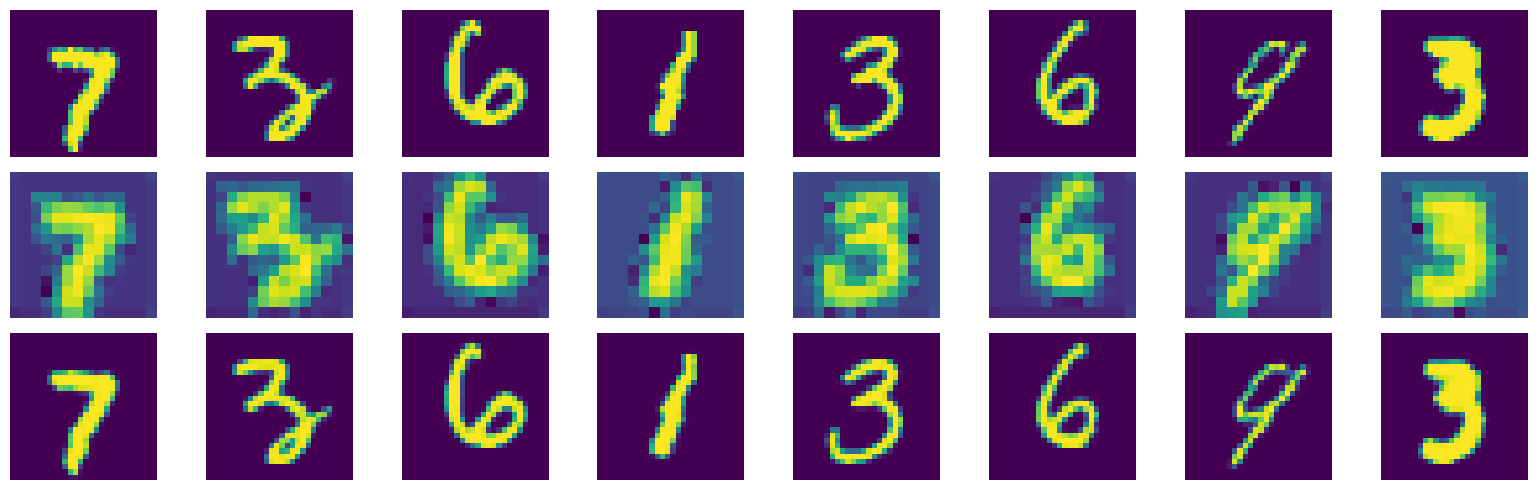

469/469 [==============================] - 4s 8ms/step - loss: 6.8777e-04 - accuracy: 0.8155
Epoch 10/15
1/1 [==============================] - 0s 11ms/step


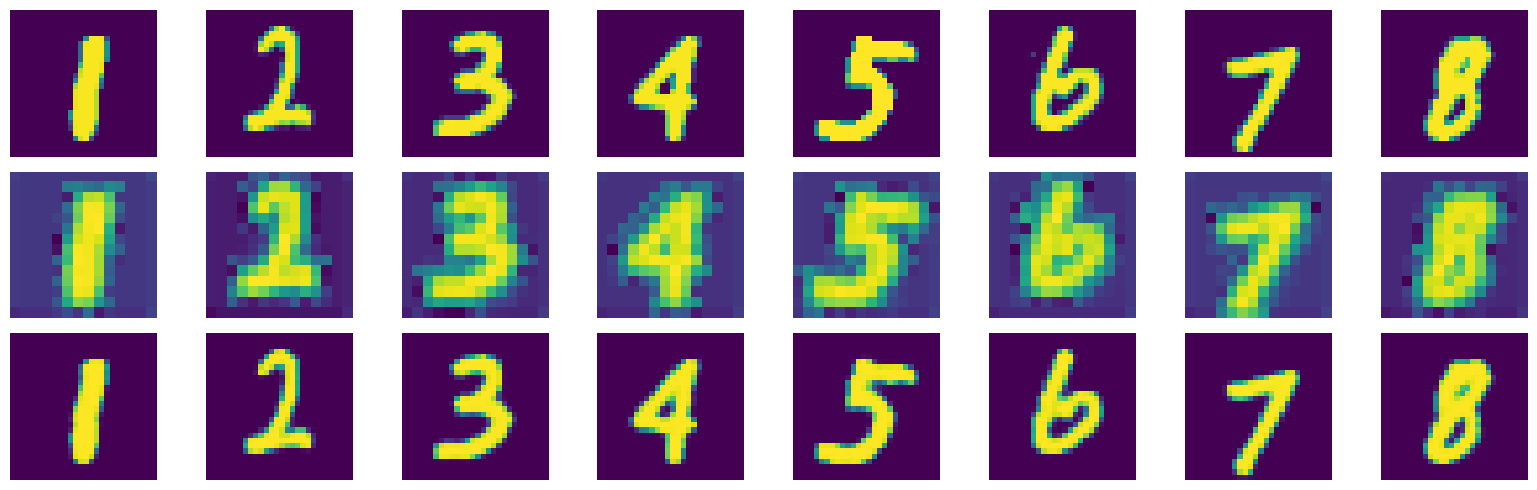

469/469 [==============================] - 3s 7ms/step - loss: 6.8413e-04 - accuracy: 0.8155
Epoch 11/15
1/1 [==============================] - 0s 11ms/step


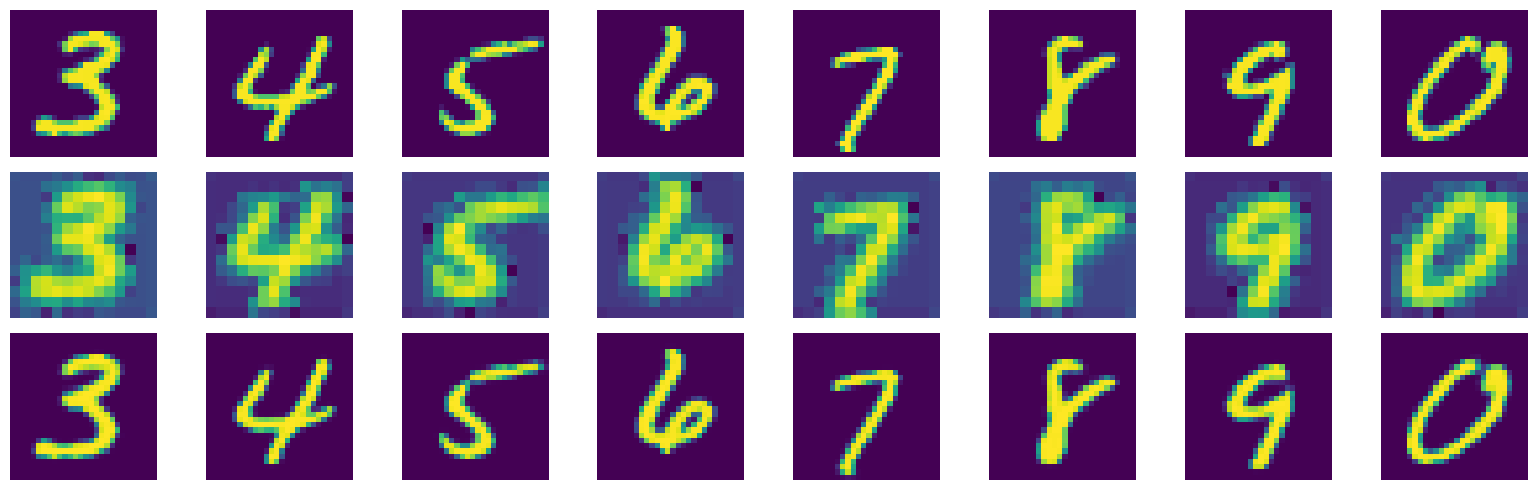

469/469 [==============================] - 3s 7ms/step - loss: 6.7982e-04 - accuracy: 0.8155
Epoch 12/15
1/1 [==============================] - 0s 11ms/step


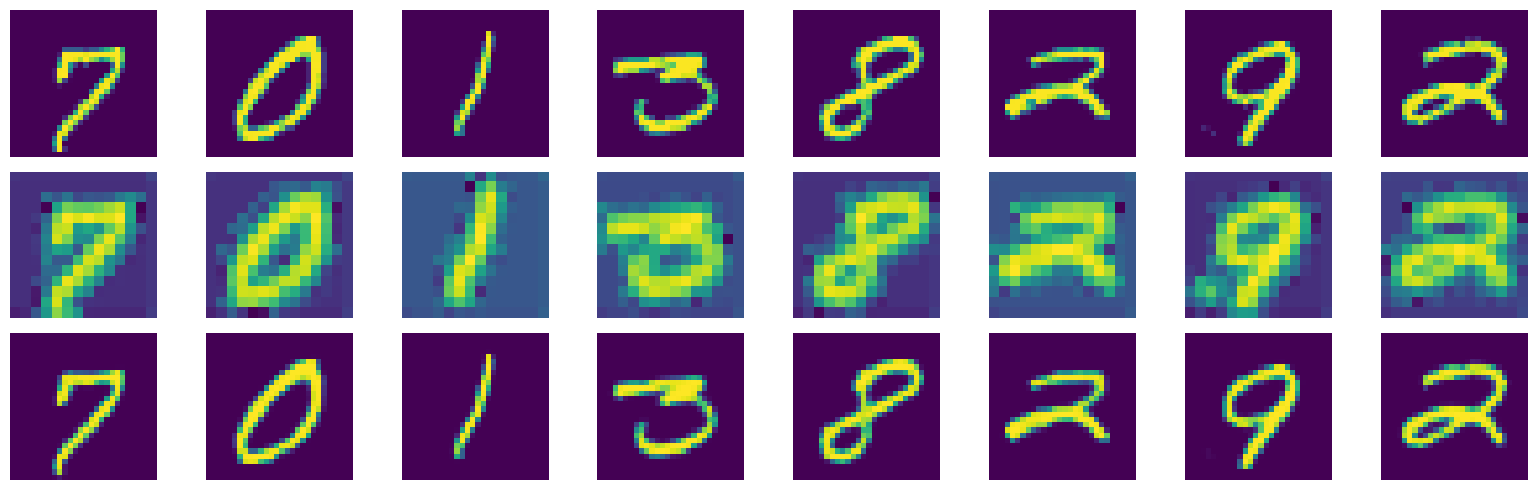

469/469 [==============================] - 3s 7ms/step - loss: 6.7625e-04 - accuracy: 0.8155
Epoch 13/15
1/1 [==============================] - 0s 12ms/step


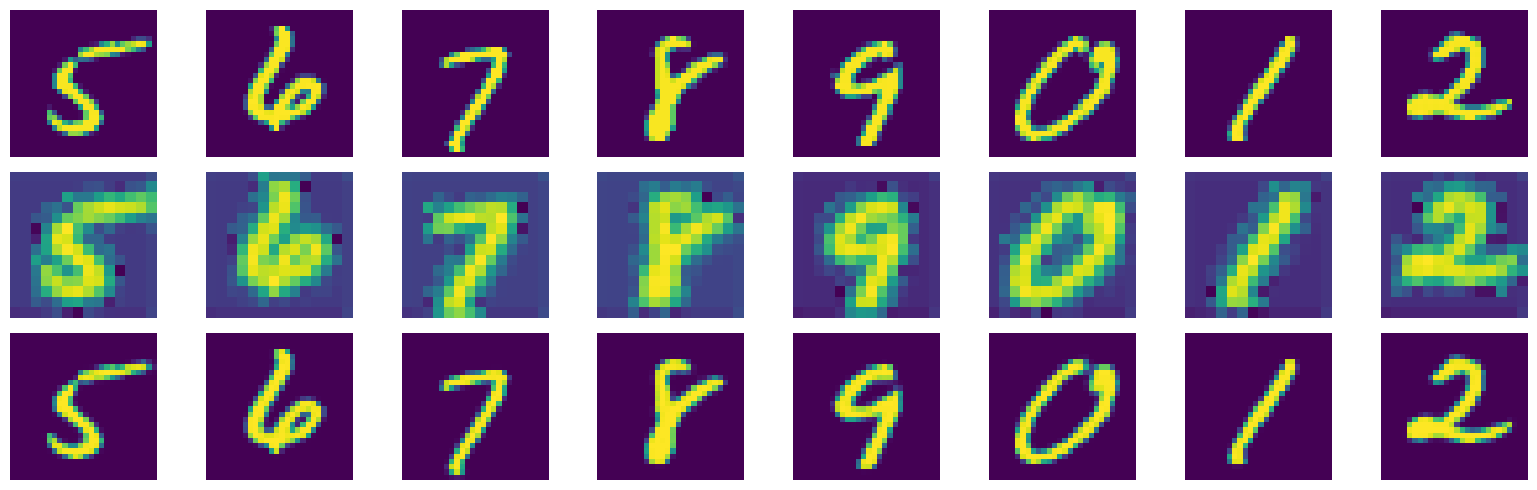

469/469 [==============================] - 4s 8ms/step - loss: 6.7277e-04 - accuracy: 0.8155
Epoch 14/15
1/1 [==============================] - 0s 11ms/step


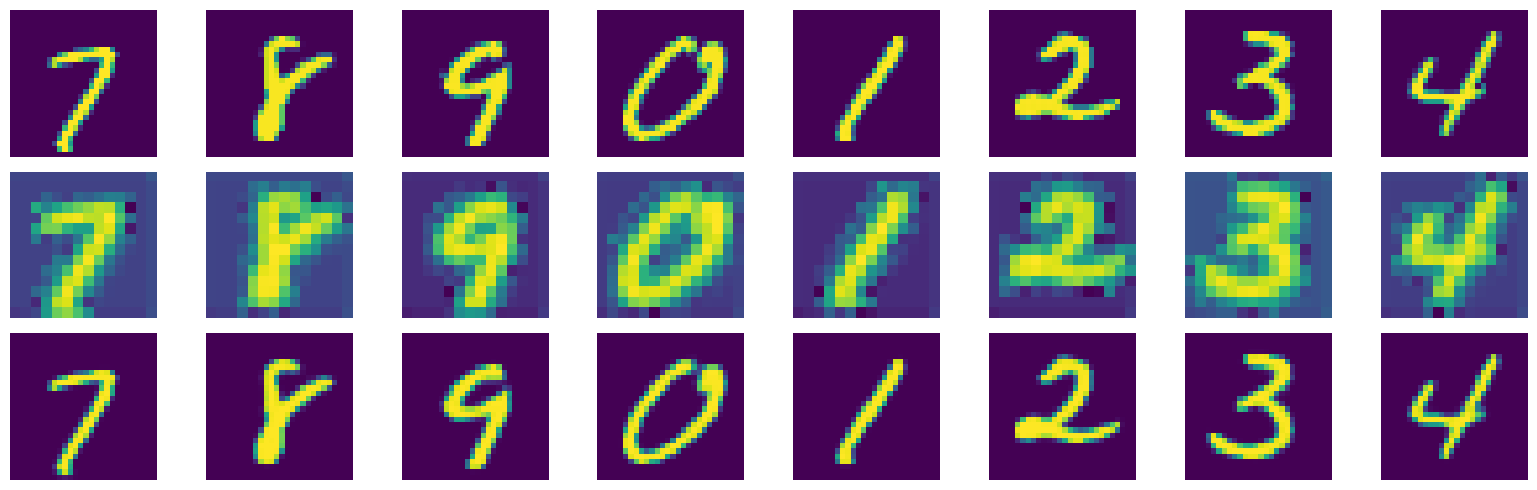

469/469 [==============================] - 3s 7ms/step - loss: 6.6885e-04 - accuracy: 0.8155
Epoch 15/15
1/1 [==============================] - 0s 11ms/step


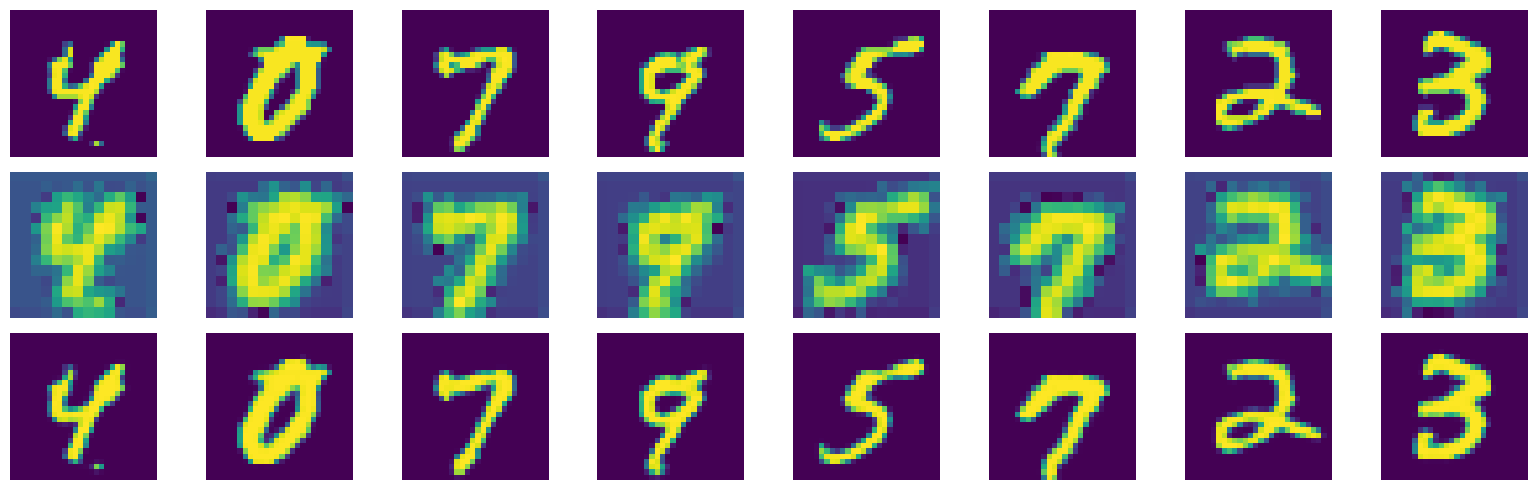

313/313 [==============================] - 0s 1ms/step - loss: 7.2307e-04 - accuracy: 0.8145
Test accuracy: 0.8144860863685608


In [147]:
# Compile the model
autoencoder.compile(optimizer='adam',
              loss='mse',
              metrics=['accuracy'])
# Train the model
autoencoder.fit(x_train, x_train,callbacks=[autoencoder_callback], epochs=15, batch_size=128)
# Evaluate the model
test_loss, test_acc = autoencoder.evaluate(x_test, x_test)
print(f'Test accuracy: {test_acc}')

Beyond compression, can we use an autoencoder as a denoiser?

In [162]:
test = x_test[0:2]
noise = np.random.rand(2, 28, 28, 1)
dirty_images = test + 0.4 * noise

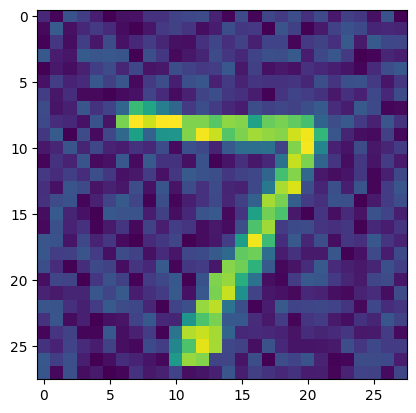

In [163]:
plt.imshow(dirty_images[0])

In [164]:
denoised = autoencoder.predict(dirty_images)

1/1 [==============================] - 0s 140ms/step


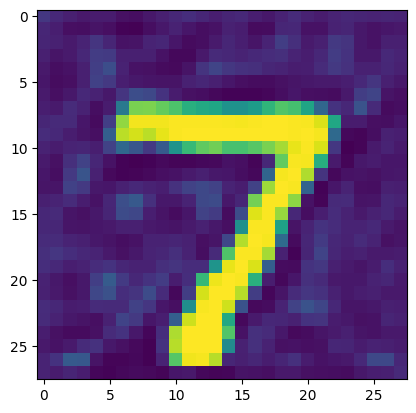

In [165]:
plt.imshow(denoised[0])

Yes we can!

## A challenge for you all 

Design constraints : 
- No more than 5 millions parameters 
- Latent space mustr have dimension (64,64)
- Latent space MUST BE ROBUST, meaning that a small change in the latent dimension is reflected by a small change in the decoded output. 

Strange ideas like ESPCN, VQVAE are welcome..

The dataset is svailable here: https://kaggle.com/datasets/9492fa65375026ab8a549610da56a5b1142fa082bccadc17ea0f28c05fba37ce
It's quite large (6GB), feel free to work with subsets

In [166]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Assuming grayscale images
input_shape = (256, 256, 1)
latent_dim = (64, 64, 1)

# The size we want to achieve in the bottleneck
target_size = (64, 64)

# Encoder model
encoder_input = layers.Input(shape=input_shape)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(encoder_input)
x = layers.MaxPooling2D((2, 2), padding='same')(x)  # Shape is now (128, 128, 32)
x = layers.Conv2D(384, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)  # Shape is now (64, 64, 64)
latent = layers.Conv2D(1, (3, 3),activation='relu', padding='same')(x)  # Shape is now (64, 64, 1)

encoder = models.Model(encoder_input, latent, name="encoder")
encoder.summary()

# Decoder model
decoder_input = layers.Input(shape=latent_dim)
x = layers.Conv2D(384, (3, 3), activation='relu', padding='same')(decoder_input)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='relu', padding='same')(x)


decoder = models.Model(decoder_input, decoded, name="decoder")
decoder.summary()
# Autoencoder model
autoencoder_input = layers.Input(shape=input_shape)
encoded_img = encoder(autoencoder_input)
decoded_img = decoder(encoded_img)
autoencoder = models.Model(autoencoder_input, decoded_img, name="autoencoder")
autoencoder.summary()
# Compile the model
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_73 (InputLayer)       [(None, 256, 256, 1)]     0         
                                                                 
 conv2d_137 (Conv2D)         (None, 256, 256, 256)     2560      
                                                                 
 max_pooling2d_50 (MaxPoolin  (None, 128, 128, 256)    0         
 g2D)                                                            
                                                                 
 conv2d_138 (Conv2D)         (None, 128, 128, 384)     885120    
                                                                 
 max_pooling2d_51 (MaxPoolin  (None, 64, 64, 384)      0         
 g2D)                                                            
                                                                 
 conv2d_139 (Conv2D)         (None, 64, 64, 1)         3457

In [ ]:
from keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
# Optimizer with weight decay
optimizer = Adam(learning_rate=1e-4, decay=1e-5)

# Compile the model with the optimizer
autoencoder.compile(optimizer=optimizer, loss='mean_squared_error')

# Learning rate reduction callback
reduce_lr = ReduceLROnPlateau(
    monitor='loss',
    factor=0.5,
    patience=20,  # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-6  # Lower bound on the learning rate
)

In [ ]:
import numpy as np
high_res_dataset = np.load('/home/faster/Documents/climate_downscaling/windspeed2010-2020CERRAitaly.npz')['arr_0'][1000]
high_res_dataset = high_res_dataset  / high_res_dataset.max()

In [ ]:
import numpy as np
import tensorflow as tf

class RandomDataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, dataset, batch_size=32, dim=(256, 256), shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.dataset = dataset
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.dataset) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Find selected samples
        X = self.dataset[indexes]

        # Since we are working with an autoencoder, input data X is the target data y
        y = X

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.dataset))
        if self.shuffle:
            np.random.shuffle(self.indexes)

# Example usage:
# Assuming 'data' is your Numpy array with shape (30000, 256, 256)
train_data_generator = RandomDataGenerator(high_res_dataset, batch_size=8, dim=(256, 256), shuffle=True)

In [ ]:
history = autoencoder.fit(train_data_generator,
                steps_per_epoch = 500,
                epochs=80)

Any consistent result below 1e-4 is considered good. Feel free to work with your datasets if you prefer.

## See you next time!

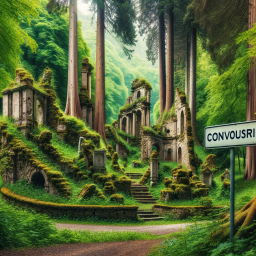